<a href="https://colab.research.google.com/github/JulioLaz/clasificacion_textos/blob/main/Clasificaci%C3%B3n_de_texto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Configurar ambiente

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install transformers
from transformers import BertForSequenceClassification
from transformers import BertTokenizer
import torch
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.5 MB/s eta 0:00:00


In [7]:
!python -m spacy download es_core_news_md
import spacy

nlp = spacy.load('es_core_news_md')

2023-09-25 14:57:42.582687: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 11.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [8]:
!pip install jellyfish
import jellyfish

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.3 MB/s eta 0:00:00


In [9]:
import re, os, random, pickle

In [10]:
import pandas as pd

ruta_archivo = "/content/drive/MyDrive/Chatbot/df_dialogo.csv"

df_dialogo = pd.read_csv(ruta_archivo)

# 2. Normalizando dialogos

In [11]:
#Función para encontrar la raiz de las palabras
def raiz(palabra):
    palabra_encontrada = palabra
    max_similitud = 0.0

    for verbo in lista_verbos:
        similitud = jellyfish.jaro_similarity(palabra, verbo)
        if similitud > max_similitud:
            max_similitud = similitud
            palabra_encontrada = verbo

    if max_similitud >= 0.93:
        return palabra_encontrada, max_similitud
    else:
        return palabra, max_similitud

In [12]:
def reemplazar_terminacion(frase):
    terminaciones = ["es", "me", "as", "ste", "te"]
    palabras = frase.split()

    for i, palabra in enumerate(palabras):
        for terminacion in terminaciones:
            if palabra.endswith(terminacion):
                palabras[i] = palabra[:-len(terminacion)] + "r"
                break

    nueva_frase = " ".join(palabras)
    return nueva_frase

In [13]:
def tratamiento_texto(texto):
  trans = str.maketrans('áéíóú','aeiou')
  texto = texto.lower()
  texto = texto.translate(trans)
  # texto = re.sub(r"[^\w\s]", '', texto)
  texto = re.sub(r"[^\w\s+\-*/]", '', texto)

  texto = " ".join(texto.split())
  return texto

frase='QUÉ DÍA ES HOY,    JULIO ALBERTO?'
texto_tratado=tratamiento_texto(frase)
print(texto_tratado)

que dia es hoy julio alberto


In [4]:
import pickle

archivo_pickle_verbos = "/content/drive/MyDrive/Chatbot/verbos/lista_verbos.pickle"
archivo_pickle_verbos_irregulares = "/content/drive/MyDrive/Chatbot/verbos/verbos_irregulares.pickle"

with open(archivo_pickle_verbos, "rb") as archivo:
        lista_verbos = pickle.load(archivo)

with open(archivo_pickle_verbos_irregulares, "rb") as archivo_irr:
        lista_verbos_irregulares = pickle.load(archivo_irr)


print(lista_verbos)
print('---------------------------------')
print(lista_verbos_irregulares)

['parar', 'recomendar', 'cancelar', 'fanatizar', 'amaran o amasen', 'exponer', 'obedecer', 'quejar', 'echar', 'legitimar', 'perjudicar', 'organizar', 'molar', 'objetar', 'considerar', 'golear', 'mover', 'acertar', 'reunir', 'regir', 'ilusionar', 'simpatizar', 'conjeturar', 'helar', 'quitar', 'amariamos', 'destacar', 'llegar', 'sincronizar', 'lesionar', 'seducir', 'asistir', 'conservar', 'acordar', 'salvar', 'relucir', 'graduar', 'forzar', 'dar', 'deplorar', 'batear', 'mofar', 'estropear', 'aplastar', 'wasapeo', 'gestionar', 'suprimir', 'gruñir', 'progresar', 'suscribir', 'noticiar', 'cavar', 'alejar', 'galopar', 'virar', 'medir', 'actualizar', 'humanizar', 'convivir', 'gratificar', 'digerir', 'tocar', 'zonificar', 'amariais', 'aterrizar', 'hojear', 'cometer', 'sufrir', 'reciclar', 'obturar', 'divertir', 'ondear', 'listar', 'determinar', 'alentar', 'sumar', 'reflexionar', 'ames', 'anotar', 'mitificar', 'escribir', 'ilustrar', 'obtener', 'subir', 'socorrer', 'desprender', 'agregar', 'gan

In [14]:
#Función para devolver los tokens normalizados del texto
def normalizar(texto):
  tokens=[]
  doc = nlp(texto)
  for t in doc:
    lemma=lista_verbos_irregulares.get(t.text, t.lemma_.split()[0])
    lemma=re.sub(r'[^\w\s+\-*/]', '', lemma)
    if t.pos_ in ('VERB','PROPN','PRON','NOUN','AUX','SCONJ','ADJ','ADV','NUM') or lemma in lista_verbos:
      if t.pos_=='VERB':
        lemma = reemplazar_terminacion(lemma)
        tokens.append(raiz(tratamiento_texto(lemma)))
      else:
        tokens.append(tratamiento_texto(lemma))

  tokens = list(dict.fromkeys(tokens))
  tokens = list(filter(None, tokens))
  cadena_texto = ' '.join(str(x) for x in tokens)
  return cadena_texto
  # return tokens

In [12]:
normalizar("texto es muy largo")

'texto ser mucho largo'

In [15]:
#Normalizando las frases
label_encoder = LabelEncoder()
df_dialogo['palabras'] = df_dialogo['dialogo'].apply(lambda x: normalizar(x))
# df_dialogo['palabras'] = df_dialogo['dialogo'].apply(lambda x: ' '.join(normalizar(x)))
df_dialogo['tipo_num'] = label_encoder.fit_transform(df_dialogo['tipo'])
df_dialogo = df_dialogo[df_dialogo.palabras.values!='']
df_dialogo

,dialogo,respuesta,tipo,interseccion,jaro_winkler,probabilidad,similarity,palabras,tipo_num
0,cual es tu nombre,"Me llamo X-Bot hijo de Madre, ¿y tú cómo te ll...",Nombre,0.666667,0.921429,0.921429,0.818180,cual ser nombre,10
1,cual es tu nombre,"Me llamo X-Bot hijo de Madre, ¡el chatbot más ...",Nombre,0.666667,0.921429,0.921429,0.818180,cual ser nombre,10
2,cual es tu nombre,¡Soy X-Bot hijo de Madre el chatbot más guay d...,Nombre,0.666667,0.921429,0.921429,0.818180,cual ser nombre,10
3,cual es el nombre de tu empresa,"Soy un chatbot, trabajo para ElProfeAlejo, y n...",Nombre,0.666667,0.892934,0.892934,0.519388,cual ser nombre empresa,10
4,cual es tu rol,Puedo responder todas tus dudas sobre Ciencia ...,Funcion,0.500000,0.885714,0.885714,0.510149,cual ser rol,8
...,...,...,...,...,...,...,...,...,...
1147,probando,¡Hola!,Saludos,0.000000,0.380952,0.380952,0.000000,"('probar', 1.0)",13
1148,por favor,¡pase usted!,Agradecimiento,0.000000,0.362434,0.362434,0.000000,favor,0
1149,okay,Me alegra haber podido ayudarte.,Agradecimiento,0.000000,0.357143,0.357143,0.000000,okay,0
1150,mi ip,Tu dirección IP es la dirección que tu disposi...,Otros,0.000000,0.323810,0.323810,0.000000,ip,12


In [14]:
# Imprimir diccionario
relacion_diccionario = {}

# Iterar sobre las filas del DataFrame
for tipo, tipo_num in zip(df_dialogo['tipo'], df_dialogo['tipo_num']):
    relacion_diccionario[tipo_num] = tipo

# Imprimir el diccionario
print(relacion_diccionario)

{10: 'Nombre', 8: 'Funcion', 14: 'Sentimiento', 11: 'Origen', 1: 'Aprendizaje', 2: 'Contacto', 5: 'Edad', 12: 'Otros', 6: 'ElProfeAlejo', 13: 'Saludos', 9: 'Identidad', 4: 'Despedida', 0: 'Agradecimiento', 3: 'Continuacion', 7: 'Error', 15: 'Usuario'}


# 3. Entrenando con Naive Bayes

In [45]:
# Separar los datos en características (X) y etiquetas (y)
X = df_dialogo['palabras']
y = df_dialogo['tipo_num']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorizar los datos de texto
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Entrenar el clasificador de Naive Bayes
modelo_NB = MultinomialNB()
modelo_NB.fit(X_train_vect, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = modelo_NB.predict(X_test_vect)

# Calcular el accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy=round(accuracy,4)*100
print("Precisión:", accuracy,'%')

Precisión: 64.35 %


In [46]:
# # Guardar el vectorizador y el modelo en un archivo
# with open('/content/drive/MyDrive/Chatbot/modelo_naive_bayes.pickle', 'wb') as archivo:
#     pickle.dump((vectorizer, modelo_NB), archivo)

# Cargar el vectorizador y el modelo desde el archivo
with open('/content/drive/MyDrive/Chatbot/modelo_naive_bayes.pickle', 'rb') as archivo:
    vectorizer, modelo_NB = pickle.load(archivo)

In [47]:
# Calcular la precisión por clase

accuracies = []
class_names = []
unique_classes = df_dialogo['tipo_num'].unique()
for cls in unique_classes:
    cls_indices = y_test == cls
    cls_accuracy = accuracy_score(y_test[cls_indices], y_pred[cls_indices])
    cls_accuracy=round(cls_accuracy,4)*100
    class_name = df_dialogo[df_dialogo.tipo_num == cls]['tipo'].unique()[0]

    accuracies.append(cls_accuracy)
    class_names.append(class_name)
    # print("Accuracy para la clase", df_dialogo[df_dialogo.tipo_num == cls]['tipo'].unique()[0], ":", cls_accuracy,'%')

accuracy_df_naive_bayes = pd.DataFrame({'Clase': class_names, '% Accuracy': accuracies})
accuracy_df_naive_bayes

,Clase,% Accuracy
0,Nombre,40.00
1,Funcion,40.00
2,Sentimiento,31.25
3,Origen,33.33
4,Aprendizaje,33.33
5,Contacto,25.00
6,Edad,33.33
7,Otros,82.67
8,ElProfeAlejo,42.86
9,Saludos,86.49


In [18]:
# Procesando la nueva frase
frase = ' '.join(normalizar('como haces para aprender tan rapido?'))
nueva_frase_vect = vectorizer.transform([frase])

# Realizar la predicción
prediccion = modelo_NB.predict(nueva_frase_vect)

diccionario = {14: 'Sentimiento', 13: 'Saludos', 10: 'Nombre', 9: 'Identidad', 6: 'ElProfeAlejo', 1: 'Aprendizaje', 8: 'Funcion', 15: 'Usuario', 11: 'Origen', 5: 'Edad', 0: 'Agradecimiento', 3: 'Continuacion', 2: 'Contacto', 4: 'Despedida', 12: 'Otros', 7: 'Error'}
llave_buscada = prediccion[0]
clase_encontrada = diccionario[llave_buscada]

print("La frase", frase, "se clasifica como: ", clase_encontrada)

La frase c o m o   ( ' h a c e r ' ,   1 . 0 )   ( ' a p r e n d e r ' ,   1 . 0 )   t a n t o   r a p i d o se clasifica como:  Otros


# 4. Entrenando con Random Forest

In [48]:
# Separar los datos en características (X) y etiquetas (y)
X = df_dialogo['palabras']
y = df_dialogo['tipo_num']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorizar los datos de texto
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Entrenar el clasificador Random Forest
Modelo_RF = RandomForestClassifier()
Modelo_RF.fit(X_train_vect, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = Modelo_RF.predict(X_test_vect)

# Calcular el accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy =round(accuracy,4)*100
print("Precisión:", accuracy,'%')

Precisión: 72.61 %


In [49]:
# # Guardar el vectorizador y el modelo en un archivo
# with open('/content/drive/MyDrive/Chatbot/modelo_random_forest.pickle', 'wb') as archivo:
#     pickle.dump((vectorizer, Modelo_RF), archivo)

# Cargar el vectorizador y el modelo desde el archivo
with open('/content/drive/MyDrive/Chatbot/modelo_random_forest.pickle', 'rb') as archivo:
    vectorizer, Modelo_RF = pickle.load(archivo)

In [50]:
# Calcular la precisión por clase

accuracies = []
class_names = []
unique_classes = df_dialogo['tipo_num'].unique()
for cls in unique_classes:
    cls_indices = y_test == cls
    cls_accuracy = accuracy_score(y_test[cls_indices], y_pred[cls_indices])
    cls_accuracy=round(cls_accuracy,4)*100
    class_name = df_dialogo[df_dialogo.tipo_num == cls]['tipo'].unique()[0]

    accuracies.append(cls_accuracy)
    class_names.append(class_name)
    # print("Accuracy para la clase", df_dialogo[df_dialogo.tipo_num == cls]['tipo'].unique()[0], ":", cls_accuracy,'%')

accuracy_df_random_forest = pd.DataFrame({'Clase': class_names, '% Accuracy': accuracies})
accuracy_df_random_forest

,Clase,% Accuracy
0,Nombre,100.00
1,Funcion,80.00
2,Sentimiento,37.50
3,Origen,33.33
4,Aprendizaje,44.44
5,Contacto,0.00
6,Edad,0.00
7,Otros,77.33
8,ElProfeAlejo,100.00
9,Saludos,81.08


In [22]:
# Procesando la nueva frase
frase = ' '.join(normalizar('como haces para aprender tan rapido?'))
nueva_frase_vect = vectorizer.transform([frase])

# Realizar la predicción
prediccion = Modelo_RF.predict(nueva_frase_vect)

diccionario = {14: 'Sentimiento', 13: 'Saludos', 10: 'Nombre', 9: 'Identidad', 6: 'ElProfeAlejo', 1: 'Aprendizaje', 8: 'Funcion', 15: 'Usuario', 11: 'Origen', 5: 'Edad', 0: 'Agradecimiento', 3: 'Continuacion', 2: 'Contacto', 4: 'Despedida', 12: 'Otros', 7: 'Error'}
llave_buscada = prediccion[0]
clase_encontrada = diccionario[llave_buscada]

print("La frase", frase, "se clasifica como: ", clase_encontrada)

La frase c o m o   ( ' h a c e r ' ,   1 . 0 )   ( ' a p r e n d e r ' ,   1 . 0 )   t a n t o   r a p i d o se clasifica como:  Otros


# 5. Entrenando con Transformers

In [23]:
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
df_train, df_test = train_test_split(df_dialogo, test_size=0.2, random_state=42)

# Cargar el modelo preentrenado de BERT para clasificación en español
model_name = 'dccuchile/bert-base-spanish-wwm-uncased'
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=df_dialogo['tipo_num'].nunique())
tokenizer = BertTokenizer.from_pretrained(model_name)

# Tokenizar y codificar las frases de entrenamiento
train_inputs = tokenizer.batch_encode_plus(
    df_train['palabras'].tolist(),
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

# Tokenizar y codificar las frases de prueba
test_inputs = tokenizer.batch_encode_plus(
    df_test['palabras'].tolist(),
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

# Preparar los datos de entrenamiento y prueba
train_data = torch.utils.data.TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], torch.tensor(df_train['tipo_num'].tolist()))
test_data = torch.utils.data.TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], torch.tensor(df_test['tipo_num'].tolist()))

# Definir el optimizador y la función de pérdida
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Entrenamiento del modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)

for epoch in range(5):  # Número de épocas de entrenamiento
    total_loss = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("Epoch:", epoch + 1, "Loss:", total_loss)

# Evaluación del modelo
model.eval()
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

with torch.no_grad():
    predictions = []
    true_labels = []

    for batch in test_dataloader:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)

        outputs = model(input_ids, attention_mask=attention_mask)

        _, predicted_labels = torch.max(outputs.logits, dim=1)

        predictions.extend(predicted_labels.tolist())
        true_labels.extend(labels.tolist())

accuracy = accuracy_score(true_labels, predictions)
accuracy=round(accuracy,4)*100
print("Precisión:", accuracy,'%')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier.bias', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 1 Loss: 136.3059482574463
Epoch: 2 Loss: 109.50041192770004
Epoch: 3 Loss: 85.73142009973526
Epoch: 4 Loss: 64.86426866054535
Epoch: 5 Loss: 46.02129527926445
Precisión: 70.0 %


In [ ]:
# # Guardar el modelo entrenado
# ruta_modelo = '/content/drive/MyDrive/Chatbot/'
# model.save_pretrained(ruta_modelo)
# tokenizer.save_pretrained(ruta_modelo)

In [40]:
#Cargar el modelo entrenado
ruta_modelo = '/content/drive/MyDrive/Chatbot/'
Modelo_TF = BertForSequenceClassification.from_pretrained(ruta_modelo)
tokenizer_TF = BertTokenizer.from_pretrained(ruta_modelo)

In [41]:
# Calcular la precisión por clase

accuracies = []
class_names = []
unique_classes = df_dialogo['tipo_num'].unique()

for class_label in unique_classes:
    # Filtrar los datos por clase
    class_data = df_dialogo[df_dialogo['tipo_num'] == class_label]

    # Preparar los datos de la clase para evaluar
    tokens = tokenizer_TF.batch_encode_plus(
        class_data['palabras'].tolist(),
        truncation=True,
        padding=True,
        return_tensors='pt'
    )

    inputs = tokens['input_ids']
    attention_mask = tokens['attention_mask']
    labels = class_data['tipo_num'].tolist()

    # Pasar los datos de la clase por el modelo
    with torch.no_grad():
        outputs = Modelo_TF(inputs, attention_mask=attention_mask)

    predicted_labels = outputs.logits.argmax(dim=1).tolist()

    # Calcular la precisión para la clase
    accuracy = accuracy_score(labels, predicted_labels)
    accuracy=round(accuracy,4)*100
    class_name = df_dialogo[df_dialogo.tipo_num == class_label]['tipo'].unique()[0]
    # print(class_name)
    accuracies.append(accuracy)
    class_names.append(class_name)
    # print("Accuracy para la clase", df_dialogo[df_dialogo.tipo_num == class_label]['tipo'].unique()[0], ":",accuracy,'%')

accuracy_df_transformers = pd.DataFrame({'Clase': class_names, '% Accuracy': accuracies})
accuracy_df_transformers


,Clase,% Accuracy
0,Nombre,70.83
1,Funcion,89.04
2,Sentimiento,91.55
3,Origen,82.00
4,Aprendizaje,76.74
5,Contacto,51.72
6,Edad,67.74
7,Otros,96.31
8,ElProfeAlejo,88.89
9,Saludos,98.33


In [51]:
import pandas as pd

# Unir los DataFrames por la columna "Clase" y renombrar columnas
merged_df = pd.merge(accuracy_df_naive_bayes, accuracy_df_random_forest, on="Clase")
merged_df = pd.merge(merged_df, accuracy_df_transformers, on="Clase", suffixes=("_naive_bayes", "_random_forest"))
merged_df.rename(columns={"Accuracy": "Accuracy_transformers"}, inplace=True)

# Mostrar el DataFrame resultante
print(merged_df)


             Clase  % Accuracy_x  % Accuracy_y  % Accuracy
0           Nombre         40.00        100.00       70.83
1          Funcion         40.00         80.00       89.04
2      Sentimiento         31.25         37.50       91.55
3           Origen         33.33         33.33       82.00
4      Aprendizaje         33.33         44.44       76.74
5         Contacto         25.00          0.00       51.72
6             Edad         33.33          0.00       67.74
7            Otros         82.67         77.33       96.31
8     ElProfeAlejo         42.86        100.00       88.89
9          Saludos         86.49         81.08       98.33
10       Identidad         61.54         92.31       88.89
11       Despedida         81.82         81.82       94.44
12  Agradecimiento         44.44         66.67       92.42
13    Continuacion         80.00         80.00       74.19
14           Error          0.00        100.00       87.50
15         Usuario         60.00         70.00       86.

In [52]:
import pandas as pd

# Unir los DataFrames por la columna "Clase"
merged_df_01 = pd.merge(accuracy_df_naive_bayes, accuracy_df_random_forest, on="Clase")
merged_df_02 = pd.merge(merged_df_01, accuracy_df_transformers, on="Clase", suffixes=("", "_transformers"))
merged_df_02.rename(columns={"% Accuracy_x": "Accuracy_naive_bayes", "% Accuracy_y": "Accuracy_random_forest","% Accuracy":"Acurracy_transformers"}, inplace=True)
merged_df_02


,Clase,Accuracy_naive_bayes,Accuracy_random_forest,Acurracy_transformers
0,Nombre,40.00,100.00,70.83
1,Funcion,40.00,80.00,89.04
2,Sentimiento,31.25,37.50,91.55
3,Origen,33.33,33.33,82.00
4,Aprendizaje,33.33,44.44,76.74
5,Contacto,25.00,0.00,51.72
6,Edad,33.33,0.00,67.74
7,Otros,82.67,77.33,96.31
8,ElProfeAlejo,42.86,100.00,88.89
9,Saludos,86.49,81.08,98.33


In [69]:
Accuracy_naive_bayes=(merged_df_02['Accuracy_naive_bayes'].sum())/len(merged_df_02)
Accuracy_random_forest=(merged_df_02['Accuracy_random_forest'].sum())/len(merged_df_02)
Acurracy_transformers=(merged_df_02['Acurracy_transformers'].sum())/len(merged_df_02)
print(Accuracy_naive_bayes)
print(Accuracy_random_forest)
print(Acurracy_transformers)

48.50375
65.28
83.5675


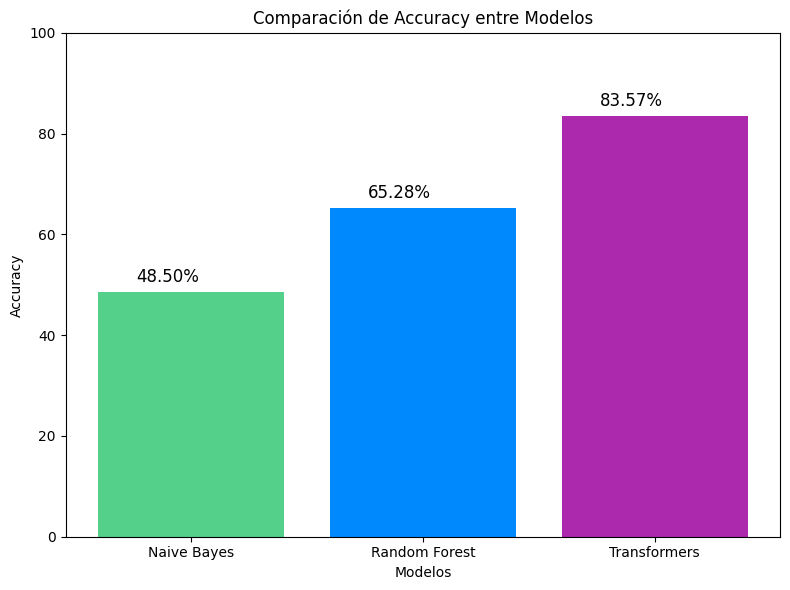

In [80]:
import matplotlib.pyplot as plt

# Valores de accuracy
accuracy_naive_bayes = (merged_df_02['Accuracy_naive_bayes'].sum()) / len(merged_df_02)
accuracy_random_forest = (merged_df_02['Accuracy_random_forest'].sum()) / len(merged_df_02)
accuracy_transformers = (merged_df_02['Acurracy_transformers'].sum()) / len(merged_df_02)

# Nombres de los modelos
model_names = ['Naive Bayes', 'Random Forest', 'Transformers']

# Valores de accuracy
accuracy_values = [accuracy_naive_bayes, accuracy_random_forest, accuracy_transformers]

# Crear la gráfica de barras
plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, accuracy_values, color=['#55d08a', '#0089fd', '#ac28ad'])
plt.xlabel('Modelos')
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy entre Modelos')
plt.ylim(0, 100)  # Establecer el rango del eje y de 0 a 100

# Agregar los valores de porcentaje arriba de cada barra
for bar, value in zip(bars, accuracy_values):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, value + 2, f'{value:.2f}%', fontsize=12, ha='center')

# Mostrar la gráfica
plt.tight_layout()
plt.show()


In [66]:
Accuracy_random_forest=(merged_df_02['Accuracy_random_forest'].sum())/len(merged_df_02)
Accuracy_random_forest

65.28

In [67]:
Acurracy_transformers=(merged_df_02['Acurracy_transformers'].sum())/len(merged_df_02)
Acurracy_transformers

83.5675

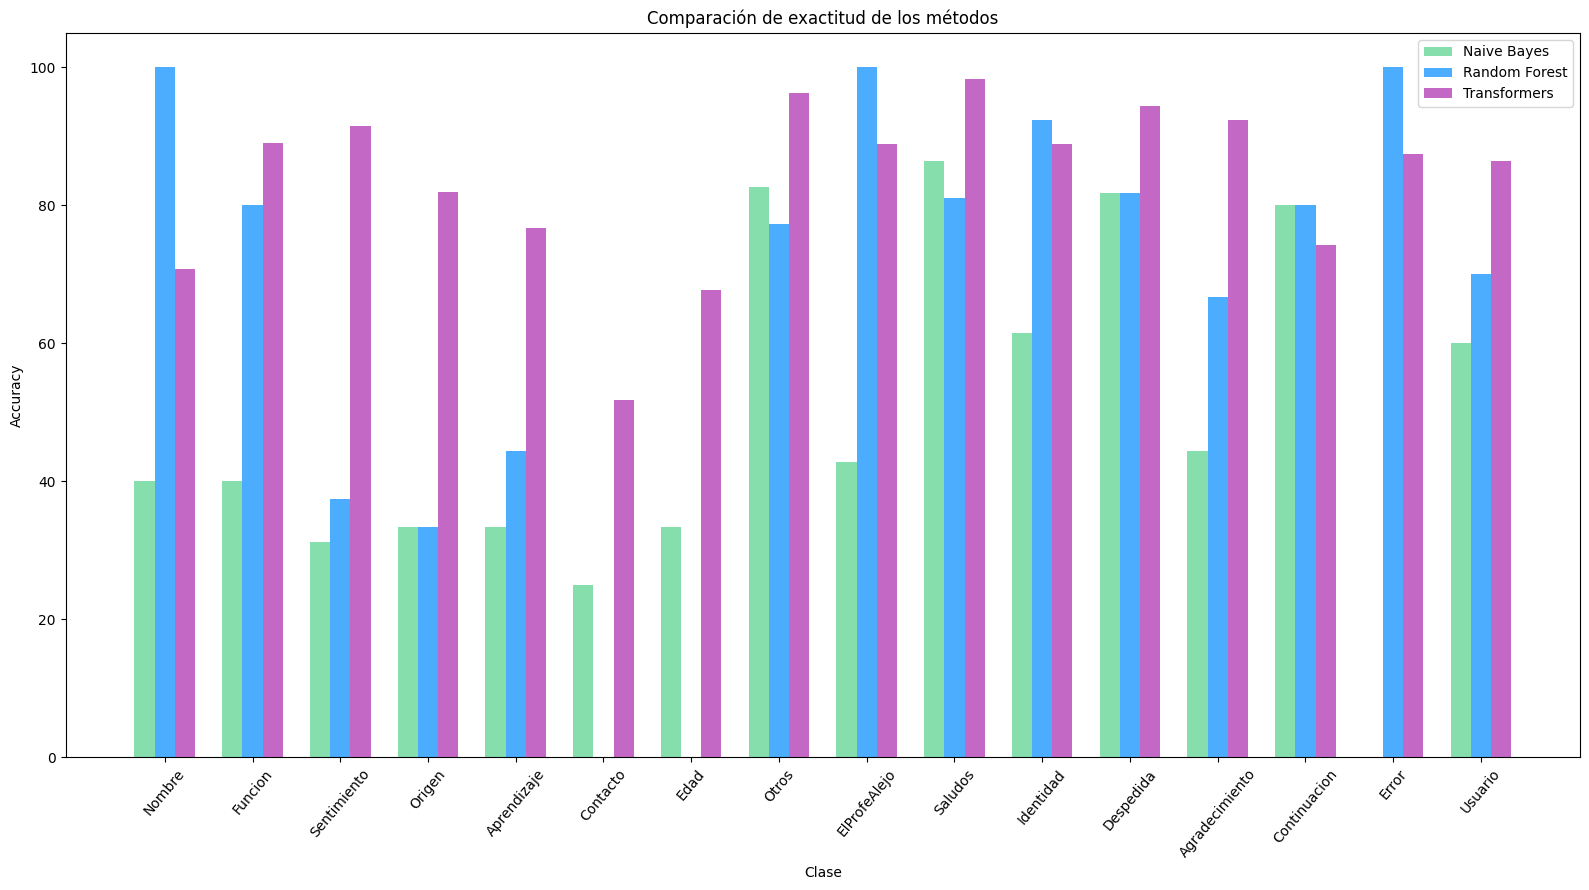

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = merged_df_02

# Configurar el tamaño de la figura
plt.figure(figsize=(16, 9))

x = np.arange(len(df))

# Ancho de las barras
bar_width = 0.23

# Crear las barras para cada tipo de modelo
plt.bar(x - bar_width, df["Accuracy_naive_bayes"], width=bar_width, label="Naive Bayes", alpha=0.7,color='#55d08a')
plt.bar(x, df["Accuracy_random_forest"], width=bar_width, label="Random Forest", alpha=0.7,color="#0089fd")
plt.bar(x + bar_width, df["Acurracy_transformers"], width=bar_width, label="Transformers", alpha=0.7,color='#ac28ad')

# Configurar etiquetas y leyenda
plt.title("Comparación de exactitud de los métodos")
plt.xlabel("Clase")
plt.ylabel("Accuracy")
plt.xticks(x, df["Clase"], rotation=50)
plt.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()


In [44]:
# Procesar nueva frase
frase = ' '.join(normalizar('donde vives?'))

# Tokenizar la frase de entrada
tokens = tokenizer_TF.encode_plus(
    frase,
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

# Obtener los input_ids y attention_mask
input_ids = tokens['input_ids']
attention_mask = tokens['attention_mask']

# Realizar la predicción
with torch.no_grad():
    outputs = Modelo_TF(input_ids, attention_mask)

# Obtener las etiquetas predichas
etiquetas_predichas = torch.argmax(outputs.logits, dim=1)

# Decodificar las etiquetas predichas
etiquetas_decodificadas = etiquetas_predichas.tolist()

diccionario = {14: 'Sentimiento', 13: 'Saludos', 10: 'Nombre', 9: 'Identidad', 6: 'ElProfeAlejo', 1: 'Aprendizaje', 8: 'Funcion', 15: 'Usuario', 11: 'Origen', 5: 'Edad', 0: 'Agradecimiento', 3: 'Continuacion', 2: 'Contacto', 4: 'Despedida', 12: 'Otros', 7: 'Error'}
llave_buscada = etiquetas_decodificadas[0]
clase_encontrada = diccionario[llave_buscada]
print("La frase", frase, "se clasifica como: ", clase_encontrada)

La frase d o n d e   ( ' v i v i r ' ,   1 . 0 ) se clasifica como:  Otros
